In [5]:
import pandas as pd
import numpy as np
import pymc as pm
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv('XRAY.csv')

# Drop non-numeric identifiers
df = df.drop(columns=["Patient_ID"])

# Encode categorical variables using one-hot encoding
categorical_cols = ["Gender", "Chest_Pain", "Fever", "Night_Sweats", "Sputum_Production", 
                    "Blood_in_Sputum", "Smoking_History", "Previous_TB_History"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Encode target variable (binary classification)
df["Class"] = (df["Class"] == "Tuberculosis").astype(int)

# Extract features and target variable
X = df.drop(columns=["Class"]).values  # Features
y = df["Class"].values  # Target

# Standardizing features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reduce dataset size for faster computation
X_train_small = X_train[:200]  # Use only 200 samples
y_train_small = y_train[:200]
n, p = X_train_small.shape  # Update dataset dimensions

# Bayesian Logistic Regression Model
with pm.Model() as logistic_model:
    # Prior on regression coefficients
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)

    # Logistic regression likelihood
    logit_p = pm.math.dot(X_train_small, betas)
    y_obs = pm.Bernoulli('y', logit_p=logit_p, observed=y_train_small)

    # Sampling with optimized settings
    idata = pm.sample(draws=300, tune=150, cores=1, target_accept=0.85, return_inferencedata=True)

# Display posterior summary
print(idata.posterior)


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas]


Sampling 2 chains for 150 tune and 300 draw iterations (300 + 600 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<xarray.Dataset> Size: 79kB
Dimensions:      (chain: 2, draw: 300, betas_dim_0: 16)
Coordinates:
  * chain        (chain) int64 16B 0 1
  * draw         (draw) int64 2kB 0 1 2 3 4 5 6 ... 293 294 295 296 297 298 299
  * betas_dim_0  (betas_dim_0) int64 128B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    betas        (chain, draw, betas_dim_0) float64 77kB -0.157 ... -0.199
Attributes:
    created_at:                 2025-03-18T20:48:23.774933+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.10.4
    sampling_time:              1.1631529331207275
    tuning_steps:               150


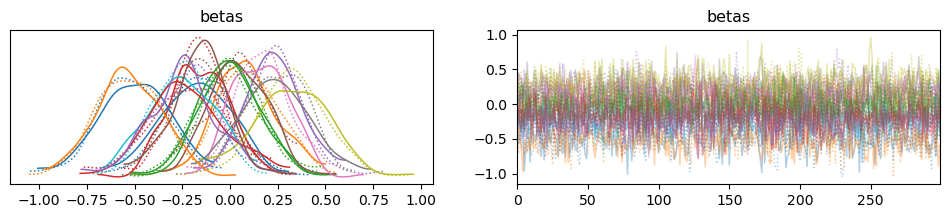

In [6]:
import arviz as az

# **Trace Plot**
az.plot_trace(idata, var_names='betas');
plt.show()

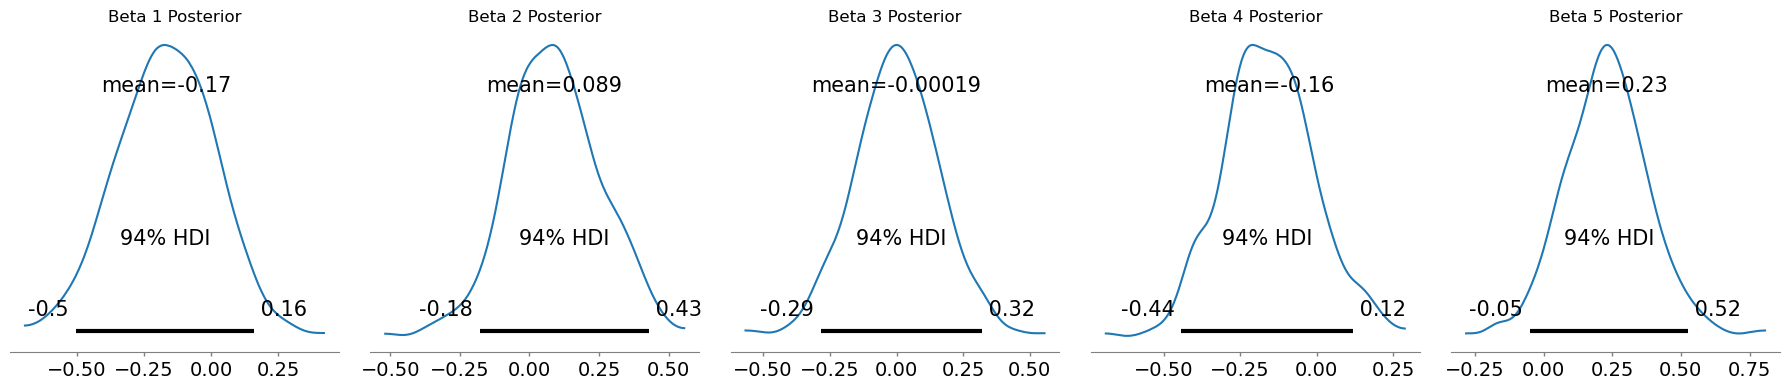

In [7]:
# Extract posterior means of betas
beta_means = idata.posterior['betas'].mean(dim=["chain", "draw"]).values

# Create subplots
fig, ax = plt.subplots(1, 5, figsize=(18, 4))

# Ensure there are at most 5 coefficients to plot
num_coeffs = min(5, beta_means.shape[0])

# Plot first 5 regression coefficients' distributions
for i in range(num_coeffs):
    az.plot_posterior(idata.posterior['betas'][:, :, i], ax=ax[i])
    ax[i].set_title(f"Beta {i+1} Posterior")

plt.tight_layout()
plt.show()

In [10]:
## DOWNSAMPLING
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv('XRAY.csv')

# Drop non-numeric identifiers
df = df.drop(columns=["Patient_ID"])

# Encode categorical variables using one-hot encoding
categorical_cols = ["Gender", "Chest_Pain", "Fever", "Night_Sweats", "Sputum_Production", 
                    "Blood_in_Sputum", "Smoking_History", "Previous_TB_History"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Encode target variable (binary classification)
df["Class"] = (df["Class"] == "Tuberculosis").astype(int)

# Extract features and target variable
X = df.drop(columns=["Class"]).values  # Features
y = df["Class"].values  # Target

# Standardizing features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Different values for n (sample size) and p (number of features)
sample_sizes = [50, 100, 200, 500]
feature_sizes = [5, 10, X.shape[1]]

# Dictionary to store results
mcmc_results = {}

# Loop through different sample sizes
for n in sample_sizes:
    for p in feature_sizes:
        # Subset dataset
        X_subset = X[:n, :p]
        y_subset = y[:n]

        # Define Bayesian Logistic Regression Model
        with pm.Model() as logistic_model:
            # Prior on regression coefficients
            betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,))

            # Logistic regression likelihood
            logit_p = pm.math.dot(X_subset, betas)
            y_obs = pm.Bernoulli('y', logit_p=logit_p, observed=y_subset)

            # Sampling with optimized settings
            idata = pm.sample(draws=500, tune=250, cores=1, target_accept=0.85, return_inferencedata=True)

            # Store MCMC diagnostics
            rhat_vals = az.rhat(idata)['betas'].values.mean()
            ess_vals = az.ess(idata)['betas'].values.mean()

            # Save results
            mcmc_results[(n, p)] = {
                "idata": idata,
                "Rhat": rhat_vals,
                "ESS": ess_vals
            }

# Display results
for key, val in mcmc_results.items():
    print(f"n={key[0]}, p={key[1]} --> Rhat={val['Rhat']:.3f}, ESS={val['ESS']:.1f}")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas]


Sampling 2 chains for 250 tune and 500 draw iterations (500 + 1_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas]


Sampling 2 chains for 250 tune and 500 draw iterations (500 + 1_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas]


Sampling 2 chains for 250 tune and 500 draw iterations (500 + 1_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas]


Sampling 2 chains for 250 tune and 500 draw iterations (500 + 1_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas]


Sampling 2 chains for 250 tune and 500 draw iterations (500 + 1_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas]


Sampling 2 chains for 250 tune and 500 draw iterations (500 + 1_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas]


Sampling 2 chains for 250 tune and 500 draw iterations (500 + 1_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas]


Sampling 2 chains for 250 tune and 500 draw iterations (500 + 1_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas]


Sampling 2 chains for 250 tune and 500 draw iterations (500 + 1_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas]


Sampling 2 chains for 250 tune and 500 draw iterations (500 + 1_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas]


Sampling 2 chains for 250 tune and 500 draw iterations (500 + 1_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas]


Sampling 2 chains for 250 tune and 500 draw iterations (500 + 1_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


n=50, p=5 --> Rhat=1.001, ESS=1125.3
n=50, p=10 --> Rhat=1.001, ESS=1344.4
n=50, p=16 --> Rhat=1.002, ESS=938.8
n=100, p=5 --> Rhat=1.001, ESS=1181.1
n=100, p=10 --> Rhat=1.003, ESS=1552.2
n=100, p=16 --> Rhat=1.001, ESS=1178.8
n=200, p=5 --> Rhat=1.001, ESS=1091.8
n=200, p=10 --> Rhat=1.002, ESS=1747.0
n=200, p=16 --> Rhat=1.002, ESS=1663.4
n=500, p=5 --> Rhat=1.002, ESS=1080.0
n=500, p=10 --> Rhat=1.002, ESS=1950.0
n=500, p=16 --> Rhat=1.002, ESS=1629.4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


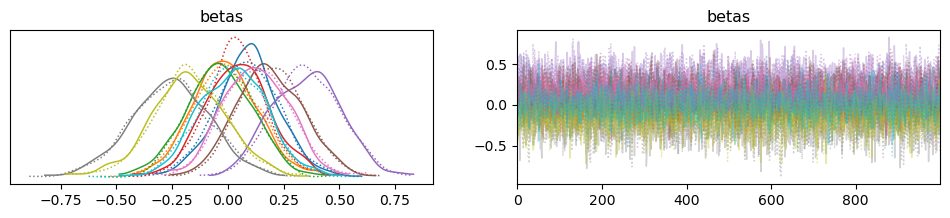


Final MCMC Diagnostics:
 - R-hat: 1.001 (should be close to 1.0)
 - ESS: 4104.3 (higher is better)


In [11]:
# Select the best (n, p) based on previous results
best_n, best_p = 200, 10  # Example choice, update based on results

# Subset data
X_final = X[:best_n, :best_p]
y_final = y[:best_n]

# Define Bayesian Logistic Regression Model
with pm.Model() as final_model:
    # Prior on regression coefficients
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(best_p,))

    # Logistic regression likelihood
    logit_p = pm.math.dot(X_final, betas)
    y_obs = pm.Bernoulli('y', logit_p=logit_p, observed=y_final)

    # Sampling
    final_idata = pm.sample(draws=1000, tune=500, cores=1, target_accept=0.9, return_inferencedata=True)

# Posterior Analysis
az.summary(final_idata, var_names=['betas'])

# Trace Plots
az.plot_trace(final_idata, var_names=['betas'])
plt.show()

# MCMC Diagnostics
rhat_final = az.rhat(final_idata)['betas'].values.mean()
ess_final = az.ess(final_idata)['betas'].values.mean()

print(f"\nFinal MCMC Diagnostics:")
print(f" - R-hat: {rhat_final:.3f} (should be close to 1.0)")
print(f" - ESS: {ess_final:.1f} (higher is better)")